In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import phik
from phik import resources
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import random
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from category_encoders import TargetEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import importlib
import functions_car
importlib.reload(functions_car)
from sklearn.compose import TransformedTargetRegressor

import copy

In [37]:
df = pd.read_csv(r"d:\Car_price_prediction\car_price_prediction.csv")
print(df.head().to_string())

         ID  Price  Levy Manufacturer    Model  Prod. year   Category Leather interior Fuel type Engine volume    Mileage  Cylinders Gear box type Drive wheels   Doors             Wheel   Color  Airbags
0  45654403  13328  1399        LEXUS   RX 450        2010       Jeep              Yes    Hybrid           3.5  186005 km          6     Automatic          4x4  04-May        Left wheel  Silver       12
1  44731507  16621  1018    CHEVROLET  Equinox        2011       Jeep               No    Petrol             3  192000 km          6     Tiptronic          4x4  04-May        Left wheel   Black        8
2  45774419   8467     -        HONDA      FIT        2006  Hatchback               No    Petrol           1.3  200000 km          4      Variator        Front  04-May  Right-hand drive   Black        2
3  45769185   3607   862         FORD   Escape        2011       Jeep              Yes    Hybrid           2.5  168966 km          4     Automatic          4x4  04-May        Left wheel   

In [38]:
SEED = 42

In [39]:
X, y, X_train, y_train, X_test, y_test, X_train_preprocessed, X_test_preprocessed= functions_car.prepare_regression_data(df)

🔥 prepare_regression_data() called — CLEAN 8-VARIANT version


✅ **Preprocessing complete.**  
Train samples: **15139**, Test samples: **3785**  
Features: **39**

➡ RETURN executed with 8 values


In [40]:
# Определяем числовые и категориальные признаки на основе X_train
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

# --- Пайплайн для числовых признаков ---
num_steps = [
    ("imputer", SimpleImputer(strategy="median")),  # Импутация медианой
    ("scaler", StandardScaler())                     # Стандартизация
]
num_transformer = Pipeline(num_steps)

# --- Пайплайн для категориальных признаков ---
cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Импутация самым частым значением
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))  # OneHot кодирование
])

# --- ColumnTransformer ---
preprocessor = ColumnTransformer([
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols)
], remainder="drop")  # Остальные колонки игнорируем


In [41]:
#Сделали список моделей для обучения всех сразу на одних и тех же данных
model = [
    ('LinearRegression', LinearRegression()),
    ('RandomForest', RandomForestRegressor(random_state=SEED)),
    ('GradientBoosting', GradientBoostingRegressor(random_state=SEED))
]

results = functions_car.evaluate_models_cv_regression_safe_new(models=model, preprocessor=preprocessor, X=X_train, y=y_train, cv=5, seed=SEED)


Кросс-валидация модели: LinearRegression
R2:    -0.0080
MSE:   46423976026.48
MAE:   15052.79
RMSE:  215462.24
SMAPE: 83.52%

Кросс-валидация модели: RandomForest
R2:    -1.1159
MSE:   97451721329.30
MAE:   11463.18
RMSE:  312172.58
SMAPE: 35.24%

Кросс-валидация модели: GradientBoosting
R2:    -0.6788
MSE:   77317790416.77
MAE:   13293.06
RMSE:  278060.77
SMAPE: 62.93%

=== Сводная таблица метрик (усреднённые по CV) ===
                        MAE              MSE        RMSE      R2   SMAPE
LinearRegression 15052.7872 46423976026.4796 215462.2381 -0.0080 83.5207
GradientBoosting 13293.0628 77317790416.7740 278060.7675 -0.6788 62.9291
RandomForest     11463.1837 97451721329.2970 312172.5826 -1.1159 35.2426


In [42]:
X_train_normalized = X_train.copy()

num_cols = ['Mileage', 'Levy']

# Нормализуем признаки чтобы не было большого разброса
scaler = StandardScaler()
X_train_normalized[num_cols] = scaler.fit_transform(X_train_normalized[num_cols])

In [43]:
def normalize_selected_features(X):
    """
    Нормализует выбранные числовые признаки ['num__Mileage', 'num__Levy']
    в переданном DataFrame с помощью StandardScaler.
    Возвращает новый DataFrame с теми же индексами и колонками.
    """
    X = X.copy()
    num_cols = ['num__Mileage', 'num__Levy']
    scaler = StandardScaler()
    X[num_cols] = scaler.fit_transform(X[num_cols])
    return X


In [44]:

num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

selected_cols = ['Mileage', 'Levy']
selected_idx = [num_cols.index(c) for c in selected_cols]

# Пайплайн для числовых признаков
def scale_selected(X):
    X_scaled = X.copy()
    X_scaled[:, selected_idx] = StandardScaler().fit_transform(X_scaled[:, selected_idx])
    return X_scaled

num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("scale_selected", FunctionTransformer(scale_selected, validate=False))
])

# Пайплайн для категориальных признаков
cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# ColumnTransformer
preprocessor_custom = ColumnTransformer([
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols)
], remainder="drop")


In [45]:
results_normilizes = functions_car.evaluate_models_cv_regression_safe_new(model, preprocessor, X_train_normalized, y_train, cv=5, seed=SEED)


Кросс-валидация модели: LinearRegression
R2:    -0.0080
MSE:   46423976026.48
MAE:   15052.79
RMSE:  215462.24
SMAPE: 83.52%

Кросс-валидация модели: RandomForest
R2:    -1.1159
MSE:   97451721329.30
MAE:   11463.18
RMSE:  312172.58
SMAPE: 35.24%

Кросс-валидация модели: GradientBoosting
R2:    -0.6788
MSE:   77317790416.77
MAE:   13293.06
RMSE:  278060.77
SMAPE: 62.93%

=== Сводная таблица метрик (усреднённые по CV) ===
                        MAE              MSE        RMSE      R2   SMAPE
LinearRegression 15052.7872 46423976026.4796 215462.2381 -0.0080 83.5207
GradientBoosting 13293.0628 77317790416.7740 278060.7675 -0.6788 62.9291
RandomForest     11463.1837 97451721329.2970 312172.5826 -1.1159 35.2426



=== 📊 Сравнение метрик: Variant 2 против Variant 1 ===
                  ΔMAE (Variant 2-Variant 1)  ΔMSE (Variant 2-Variant 1)  ΔRMSE (Variant 2-Variant 1)  ΔR2 (Variant 2-Variant 1)  ΔSMAPE (Variant 2-Variant 1)
Model                                                                                                                                                         
LinearRegression                     -0.0000                      0.0000                       0.0000                     0.0000                       -0.0000
GradientBoosting                      0.0000                      0.0000                       0.0000                     0.0000                        0.0000
RandomForest                          0.0000                      0.0000                       0.0000                     0.0000                        0.0000


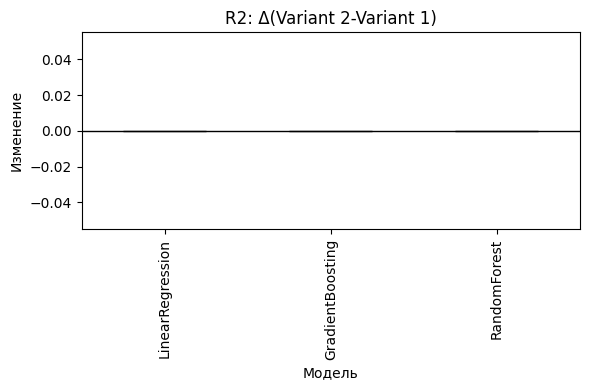

,ΔMAE (Variant 2-Variant 1),ΔMSE (Variant 2-Variant 1),ΔRMSE (Variant 2-Variant 1),ΔR2 (Variant 2-Variant 1),ΔSMAPE (Variant 2-Variant 1),Trend
Model,,,,,,
LinearRegression,-0,0,0,0,-0,↑ ↓ ↓ ↓ ↑
GradientBoosting,0,0,0,0,0,↓ ↓ ↓ ↓ ↓
RandomForest,0,0,0,0,0,↓ ↓ ↓ ↓ ↓


In [ ]:
functions_car.compare_regression_metrics(results, results_normilizes)#результаты не изменились

In [196]:
X_train_preprocessed.describe()

,one_hot__Category_Cabriolet,one_hot__Category_Coupe,one_hot__Category_Goods wagon,one_hot__Category_Hatchback,one_hot__Category_Jeep,one_hot__Category_Limousine,one_hot__Category_Microbus,one_hot__Category_Minivan,one_hot__Category_Pickup,one_hot__Category_Sedan,...,num__Model,num__Prod. year,num__Leather interior,num__Mileage,num__Cylinders,num__Doors,num__Color,num__Airbags,num__is_turbo,num__engine_size
count,"15,139","15,139","15,139","15,139","15,139","15,139","15,139","15,139","15,139","15,139",...,"15,139","15,139","15,139","15,139","15,139","15,139","15,139","15,139","15,139","15,139"
mean,0,0,0,0,0,0,0,0,0,0,...,9,"2,011",1,"1,501,842",5,4,9,7,0,2
std,0,0,0,0,0,0,0,0,0,0,...,1,6,0,"46,473,198",1,0,0,4,0,1
min,0,0,0,0,0,0,0,0,0,0,...,7,"1,939",0,0,1,2,8,0,0,0
25%,0,0,0,0,0,0,0,0,0,0,...,9,"2,009",0,"70,000",4,4,9,4,0,2
50%,0,0,0,0,0,0,0,0,0,0,...,9,"2,012",1,"126,410",4,4,9,6,0,2
75%,0,0,0,0,1,0,0,0,0,1,...,9,"2,015",1,"189,530",4,4,9,12,0,2
max,1,1,1,1,1,1,1,1,1,1,...,11,"2,020",1,"2,147,483,647",16,6,10,16,1,20


In [197]:
X_train_preprocessed['num__Levy'].value_counts()

num__Levy
0        4583
765       397
891       355
639       329
640       326
         ... 
2,705       1
1,357       1
748         1
3,699       1
3,989       1
Name: count, Length: 526, dtype: int64

In [246]:
X_train.head()

,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,is_turbo,engine_size
8727,639,10,10,2014,Jeep,1,Diesel,151000,4,Automatic,Front,4,Left wheel,9,4,0,2
4808,1811,9,9,2010,Jeep,1,Petrol,260771,8,Automatic,4x4,4,Left wheel,9,0,0,5
579,0,9,10,2012,Jeep,1,Petrol,167000,8,Tiptronic,4x4,4,Left wheel,9,10,1,5
8139,1185,9,9,2009,Jeep,0,Petrol,115000,6,Automatic,4x4,4,Left wheel,9,12,0,2
6554,900,10,10,2015,Jeep,1,Petrol,107106,4,Automatic,Front,4,Left wheel,9,12,0,2


In [47]:
#Добавили новые признаки такие как сколько лет машине пробег в год и тд
X_train_new = X_train.copy()
X_train_new["car_age"] = 2025 - X_train_new["Prod. year"]
X_train_new["mileage_per_year"] = X_train_new["Mileage"] / X_train_new["car_age"].replace(0, 1)
X_train_new["volume_per_cyl"] = X_train_new["engine_size"] / X_train_new["Cylinders"].replace(0, 1)
X_train_new["mileage_group"] = pd.cut(X_train_new["Mileage"], bins=[0, 50000, 100000, 200000, 300000, np.inf],
                             labels=[0,1,2,3,4], include_lowest=True)

In [17]:

def add_car_features(X, feature_names):
    """
    Добавление новых признаков на основе исходных колонок.
    X: numpy array после preprocessor
    feature_names: список названий колонок после ColumnTransformer
    """
    X_df = pd.DataFrame(X, columns=feature_names)

    # Новые признаки
    X_df["car_age"] = 2025 - X_df["num__Prod. year"]
    X_df["mileage_per_year"] = X_df["num__Mileage"] / X_df["car_age"].replace(0, 1)
    X_df["volume_per_cyl"] = X_df["num__engine_size"] / X_df["num__Cylinders"].replace(0, 1)
    X_df["mileage_group"] = pd.cut(
        X_df["num__Mileage"],
        bins=[0, 50000, 100000, 200000, 300000, np.inf],
        labels=[0,1,2,3,4],
        include_lowest=True
    )

    return X_df.values  # Pipeline требует numpy array

# После вашего существующего preprocessor
pipeline = Pipeline([
    ("preprocessor", preprocessor),  # ваш ColumnTransformer
    ("feature_engineering", FunctionTransformer(
        func=lambda X: add_car_features(X, preprocessor.get_feature_names_out()),
        validate=False
    ))
])


In [48]:
results_new =functions_car.evaluate_models_cv_regression_safe_new(model, preprocessor, X_train_new, y_train, cv=5, seed=SEED)


Кросс-валидация модели: LinearRegression
R2:    -0.0080
MSE:   46423976026.48
MAE:   15052.79
RMSE:  215462.24
SMAPE: 83.52%

Кросс-валидация модели: RandomForest
R2:    -1.1159
MSE:   97451721329.30
MAE:   11463.18
RMSE:  312172.58
SMAPE: 35.24%

Кросс-валидация модели: GradientBoosting
R2:    -0.6788
MSE:   77317790416.77
MAE:   13293.06
RMSE:  278060.77
SMAPE: 62.93%

=== Сводная таблица метрик (усреднённые по CV) ===
                        MAE              MSE        RMSE      R2   SMAPE
LinearRegression 15052.7872 46423976026.4796 215462.2381 -0.0080 83.5207
GradientBoosting 13293.0628 77317790416.7740 278060.7675 -0.6788 62.9291
RandomForest     11463.1837 97451721329.2970 312172.5826 -1.1159 35.2426



=== 📊 Сравнение метрик: Variant 2 против Variant 1 ===
                  ΔMAE (Variant 2-Variant 1)  ΔMSE (Variant 2-Variant 1)  ΔRMSE (Variant 2-Variant 1)  ΔR2 (Variant 2-Variant 1)  ΔSMAPE (Variant 2-Variant 1)
Model                                                                                                                                                         
LinearRegression                      0.0000                      0.0000                       0.0000                     0.0000                        0.0000
GradientBoosting                      0.0000                      0.0000                       0.0000                     0.0000                        0.0000
RandomForest                          0.0000                      0.0000                       0.0000                     0.0000                        0.0000


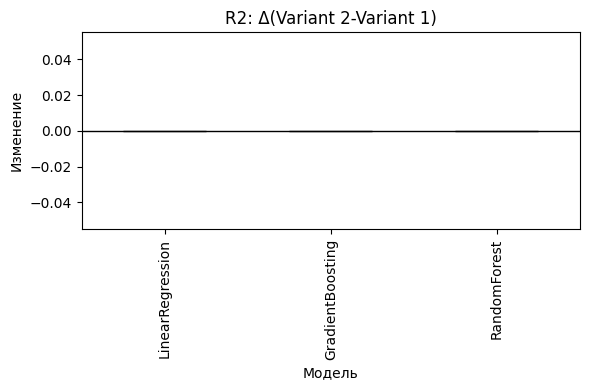

,ΔMAE (Variant 2-Variant 1),ΔMSE (Variant 2-Variant 1),ΔRMSE (Variant 2-Variant 1),ΔR2 (Variant 2-Variant 1),ΔSMAPE (Variant 2-Variant 1),Trend
Model,,,,,,
LinearRegression,0,0,0,0,0,↓ ↓ ↓ ↓ ↓
GradientBoosting,0,0,0,0,0,↓ ↓ ↓ ↓ ↓
RandomForest,0,0,0,0,0,↓ ↓ ↓ ↓ ↓


In [ ]:
functions_car.compare_regression_metrics(results, results_new)#результаты не изменились

In [20]:
print(len(X_train_preprocessed_new), len(y_train))
print(X_train_preprocessed_new.index.equals(y_train.index))

NameError: name 'X_train_preprocessed_new' is not defined

(array([1.5138e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000000e+00, 2.63075090e+06, 5.26150080e+06, 7.89225070e+06,
        1.05230006e+07, 1.31537505e+07, 1.57845004e+07, 1.84152503e+07,
        2.10460002e+07, 2.36767501e+07, 2.63075000e+07]),
 <BarContainer object of 10 artists>)

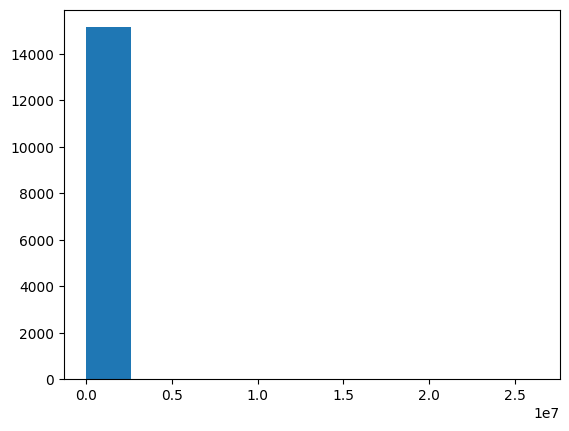

In [50]:
y_train.describe()
y_train.isna().sum()
plt.hist(y_train, bins=10)


NaN в y_train: 0
count       15,139
mean        18,921
std        214,614
min              1
25%          5,331
50%         13,172
75%         22,000
max     26,307,500
Name: Price, dtype: float64

Минимум: 1
Максимум: 26307500

Квантили:
0        1
0    5,331
0   13,172
1   22,000
1   38,732
1   49,237
1   83,107
Name: Price, dtype: float64


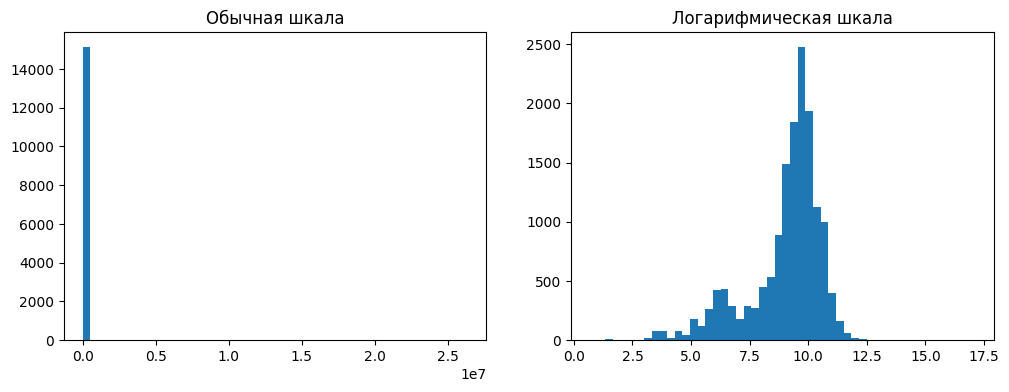

In [51]:
#Смотрим на масштаб таргет переменной обычной и если применить логарифм
print("NaN в y_train:", y_train.isna().sum())
print(y_train.describe())

# Проверим уникальные диапазоны
print("\nМинимум:", y_train.min())
print("Максимум:", y_train.max())

# 1. Посмотрим квантильное распределение
print("\nКвантили:")
print(y_train.quantile([0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

# 2. Нарисуем две гистограммы: обычную и в логарифмической шкале
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].hist(y_train, bins=50)
ax[0].set_title("Обычная шкала")

ax[1].hist(np.log1p(y_train), bins=50)
ax[1].set_title("Логарифмическая шкала")
plt.show()


In [52]:
y_train_log = np.log1p(y_train)#Попробуем обучить модель на лог таргете чтобы не было таких огромных выбросов

In [53]:
print(y_train)

8727     40976
4808       941
579      75266
8139     12544
6554       941
         ...  
11413    18817
12106     8938
5429      2509
861      18817
16027     5488
Name: Price, Length: 15139, dtype: int64


In [54]:
results_new_log = functions_car.evaluate_models_cv_regression_safe_new(model,preprocessor, X_train_new, y_train, cv=5, seed=SEED, log=True)


Кросс-валидация модели: LinearRegression
R2:    0.0018
MSE:   45972159147.09
MAE:   10932.88
RMSE:  214411.19
SMAPE: 71.97%

Кросс-валидация модели: RandomForest
R2:    0.0041
MSE:   45869201061.66
MAE:   6550.31
RMSE:  214170.96
SMAPE: 37.87%

Кросс-валидация модели: GradientBoosting
R2:    0.0028
MSE:   45927705591.91
MAE:   8942.00
RMSE:  214307.50
SMAPE: 59.59%

=== Сводная таблица метрик (усреднённые по CV) ===
                        MAE              MSE        RMSE     R2   SMAPE
RandomForest      6550.3116 45869201061.6641 214170.9622 0.0041 37.8701
GradientBoosting  8942.0035 45927705591.9130 214307.5024 0.0028 59.5935
LinearRegression 10932.8763 45972159147.0928 214411.1917 0.0018 71.9712



=== 📊 Сравнение метрик: Variant 2 против Variant 1 ===
                  ΔMAE (Variant 2-Variant 1)  ΔMSE (Variant 2-Variant 1)  ΔRMSE (Variant 2-Variant 1)  ΔR2 (Variant 2-Variant 1)  ΔSMAPE (Variant 2-Variant 1)
Model                                                                                                                                                         
GradientBoosting                  -4351.0594           -31390084824.8610                  -63753.2651                     0.6816                       -3.3356
LinearRegression                  -4119.9108             -451816879.3868                   -1051.0463                     0.0098                      -11.5495
RandomForest                      -4912.8721           -51582520267.6329                  -98001.6204                     1.1200                        2.6276


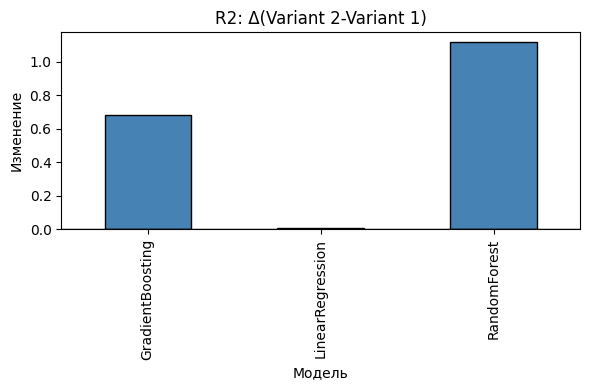

,ΔMAE (Variant 2-Variant 1),ΔMSE (Variant 2-Variant 1),ΔRMSE (Variant 2-Variant 1),ΔR2 (Variant 2-Variant 1),ΔSMAPE (Variant 2-Variant 1),Trend
Model,,,,,,
GradientBoosting,"-4,351","-31,390,084,825","-63,753",1,-3,↑ ↑ ↑ ↑ ↑
LinearRegression,"-4,120","-451,816,879","-1,051",0,-12,↑ ↑ ↑ ↑ ↑
RandomForest,"-4,913","-51,582,520,268","-98,002",1,3,↑ ↑ ↑ ↑ ↓


In [ ]:
functions_car.compare_regression_metrics(results.sort_index(), results_new_log.sort_index())#Все метрики улучшились

In [56]:
pd.options.display.float_format = '{:,.0f}'.format

In [57]:
y_train.describe(percentiles=[0.9, 0.95, 0.99, 0.999])#Смотрим на распределенгие данных и видим что есть огромные выбросы после 99 перцентиля

count       15,139
mean        18,921
std        214,614
min              1
50%         13,172
90%         38,732
95%         49,237
99%         83,107
99.9%      172,486
max     26,307,500
Name: Price, dtype: float64

In [58]:
#Убираем выбросы которые находятся выше 99 перцентился чтобы не портили нашу модель и слишком сильно не подстраивались под отгромные выбросы
mask = y_train <= y_train.quantile(0.99)
y_train_filtered = y_train[mask]
X_train_filtered = X_train[mask]


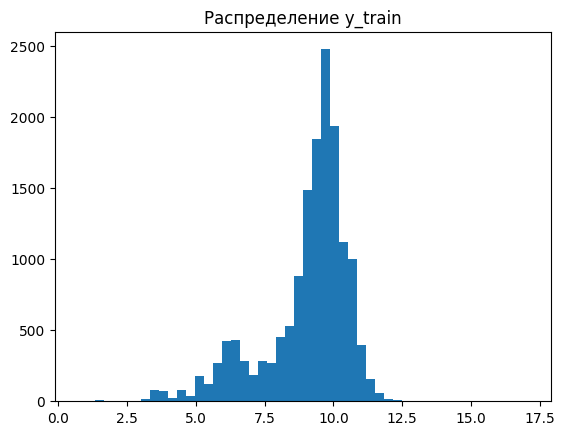

Минимум: 0.6931471805599453
Квантиль 0.01: 3.871201010907891


In [59]:
import numpy as np
import matplotlib.pyplot as plt

plt.hist(y_train_log, bins=50)
plt.title("Распределение y_train")
plt.show()

print("Минимум:", np.min(y_train_log))
print("Квантиль 0.01:", np.quantile(y_train_log, 0.01))


In [60]:
results_new_filtered = functions_car.evaluate_models_cv_regression_safe_new(model, preprocessor, X_train_filtered, y_train_filtered, cv=5, seed=SEED, log=True)#Видим чсильное улучшение результата после отброса выбросов и использование лог таргета


Кросс-валидация модели: LinearRegression
R2:    0.2003
MSE:   172692719.86
MAE:   8461.93
RMSE:  13141.26
SMAPE: 71.82%

Кросс-валидация модели: RandomForest
R2:    0.7094
MSE:   62749591.70
MAE:   4267.83
RMSE:  7921.46
SMAPE: 37.69%

Кросс-валидация модели: GradientBoosting
R2:    0.4492
MSE:   118951689.88
MAE:   6568.89
RMSE:  10906.50
SMAPE: 59.52%

=== Сводная таблица метрик (усреднённые по CV) ===
                       MAE            MSE       RMSE     R2   SMAPE
RandomForest     4267.8345  62749591.7012  7921.4640 0.7094 37.6874
GradientBoosting 6568.8862 118951689.8798 10906.4976 0.4492 59.5248
LinearRegression 8461.9255 172692719.8619 13141.2602 0.2003 71.8155



=== 📊 Сравнение метрик: Variant 2 против Variant 1 ===
                  ΔMAE (Variant 2-Variant 1)  ΔMSE (Variant 2-Variant 1)  ΔRMSE (Variant 2-Variant 1)  ΔR2 (Variant 2-Variant 1)  ΔSMAPE (Variant 2-Variant 1)
Model                                                                                                                                                         
GradientBoosting                  -2373.1173           -45808753902.0332                 -203401.0048                     0.4464                       -0.0687
LinearRegression                  -2470.9508           -45799466427.2309                 -201269.9315                     0.1985                       -0.1556
RandomForest                      -2282.4770           -45806451469.9629                 -206249.4982                     0.7054                       -0.1827


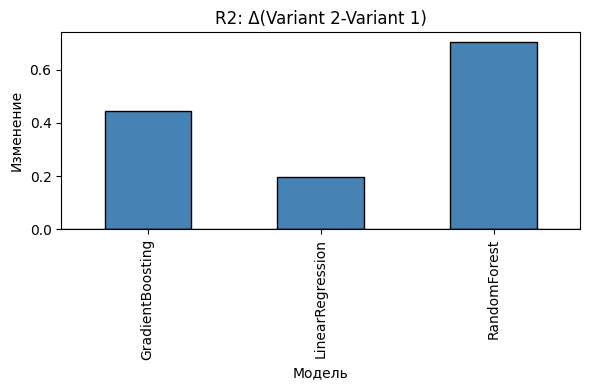

,ΔMAE (Variant 2-Variant 1),ΔMSE (Variant 2-Variant 1),ΔRMSE (Variant 2-Variant 1),ΔR2 (Variant 2-Variant 1),ΔSMAPE (Variant 2-Variant 1),Trend
Model,,,,,,
GradientBoosting,"-2,373","-45,808,753,902","-203,401",0,-0,↑ ↑ ↑ ↑ ↑
LinearRegression,"-2,471","-45,799,466,427","-201,270",0,-0,↑ ↑ ↑ ↑ ↑
RandomForest,"-2,282","-45,806,451,470","-206,249",1,-0,↑ ↑ ↑ ↑ ↑


In [ ]:
functions_car.compare_regression_metrics(results_new_log.sort_index(), results_new_filtered.sort_index())#Все метрики улучшились

In [62]:
X_train_preprocessed_new_filtered = X_train_preprocessed_new[mask]
results_new_filtered_2 = functions_car.evaluate_models_cv_regression(model, X_train_preprocessed_new_filtered, y_train_filtered, cv=5, seed=SEED, log=True)

NameError: name 'X_train_preprocessed_new' is not defined

In [63]:
#Пробуем добавить лог признаки пробега и levy для нормализации данных, а также др преобразования
X_train_filtered_new = X_train_filtered.copy()
log_transformer = FunctionTransformer(np.log1p, validate=False)
X_train_filtered_new['Mileage_log'] = log_transformer.transform(X_train_filtered_new[['Mileage']])
X_train_filtered_new['Levy_log'] = log_transformer.transform(X_train_filtered_new[['Levy']])
X_train_filtered_new['car_age'] = 2025 - X_train_filtered_new['Prod. year']
X_train_filtered_new['mileage_per_year'] = X_train_filtered_new['Mileage'] / X_train_filtered_new['car_age']



In [64]:
results_new_log_2 = functions_car.evaluate_models_cv_regression_safe_new(model, preprocessor,  X_train_filtered_new, y_train_filtered, cv=5, seed=SEED, log=True)#Результаты модели особо не изменились


Кросс-валидация модели: LinearRegression
R2:    0.2003
MSE:   172692719.86
MAE:   8461.93
RMSE:  13141.26
SMAPE: 71.82%

Кросс-валидация модели: RandomForest
R2:    0.7094
MSE:   62749591.70
MAE:   4267.83
RMSE:  7921.46
SMAPE: 37.69%

Кросс-валидация модели: GradientBoosting
R2:    0.4492
MSE:   118951689.88
MAE:   6568.89
RMSE:  10906.50
SMAPE: 59.52%

=== Сводная таблица метрик (усреднённые по CV) ===
                       MAE            MSE       RMSE     R2   SMAPE
RandomForest     4267.8345  62749591.7012  7921.4640 0.7094 37.6874
GradientBoosting 6568.8862 118951689.8798 10906.4976 0.4492 59.5248
LinearRegression 8461.9255 172692719.8619 13141.2602 0.2003 71.8155



=== 📊 Сравнение метрик: Variant 2 против Variant 1 ===
                  ΔMAE (Variant 2-Variant 1)  ΔMSE (Variant 2-Variant 1)  ΔRMSE (Variant 2-Variant 1)  ΔR2 (Variant 2-Variant 1)  ΔSMAPE (Variant 2-Variant 1)
Model                                                                                                                                                         
GradientBoosting                      0.0000                      0.0000                       0.0000                     0.0000                        0.0000
LinearRegression                      0.0000                      0.0000                       0.0000                     0.0000                        0.0000
RandomForest                          0.0000                      0.0000                       0.0000                     0.0000                        0.0000


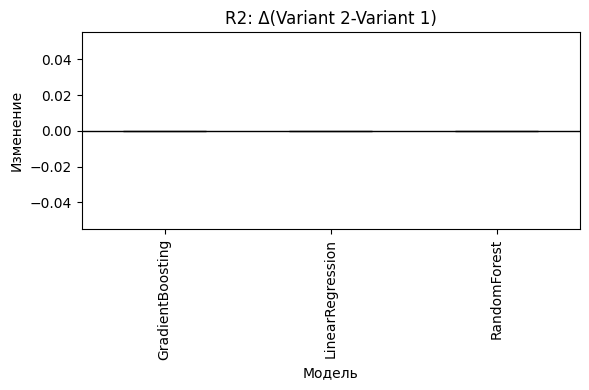

,ΔMAE (Variant 2-Variant 1),ΔMSE (Variant 2-Variant 1),ΔRMSE (Variant 2-Variant 1),ΔR2 (Variant 2-Variant 1),ΔSMAPE (Variant 2-Variant 1),Trend
Model,,,,,,
GradientBoosting,0,0,0,0,0,↓ ↓ ↓ ↓ ↓
LinearRegression,0,0,0,0,0,↓ ↓ ↓ ↓ ↓
RandomForest,0,0,0,0,0,↓ ↓ ↓ ↓ ↓


In [ ]:
functions_car.compare_regression_metrics(results_new_filtered.sort_index(), results_new_log_2.sort_index())#Результаты не изменились

In [66]:
X_train_filtered_new_del = X_train_filtered_new.copy()
X_train_filtered_new_del.drop(['Mileage', 'Levy', 'Prod. year'], axis=1, inplace=True)

In [67]:
results_new_del = functions_car.evaluate_models_cv_regression_safe_new(model, preprocessor, X_train_filtered_new_del, y_train_filtered, cv=5, seed=SEED, log=True)#Результаты модели особо не изменились


Кросс-валидация модели: LinearRegression
R2:    0.1307
MSE:   187721145.38
MAE:   8853.06
RMSE:  13701.14
SMAPE: 73.52%

Кросс-валидация модели: RandomForest
R2:    0.5160
MSE:   104522530.00
MAE:   6002.27
RMSE:  10223.63
SMAPE: 52.95%

Кросс-валидация модели: GradientBoosting
R2:    0.3033
MSE:   150456780.30
MAE:   7570.33
RMSE:  12266.08
SMAPE: 64.99%

=== Сводная таблица метрик (усреднённые по CV) ===
                       MAE            MSE       RMSE     R2   SMAPE
RandomForest     6002.2701 104522530.0045 10223.6261 0.5160 52.9491
GradientBoosting 7570.3292 150456780.2996 12266.0825 0.3033 64.9928
LinearRegression 8853.0633 187721145.3758 13701.1366 0.1307 73.5202



=== 📊 Сравнение метрик: Variant 2 против Variant 1 ===
                  ΔMAE (Variant 2-Variant 1)  ΔMSE (Variant 2-Variant 1)  ΔRMSE (Variant 2-Variant 1)  ΔR2 (Variant 2-Variant 1)  ΔSMAPE (Variant 2-Variant 1)
Model                                                                                                                                                         
GradientBoosting                   1001.4430               31505090.4198                    1359.5849                    -0.1459                        5.4680
LinearRegression                    391.1377               15028425.5139                     559.8764                    -0.0696                        1.7046
RandomForest                       1734.4356               41772938.3033                    2302.1621                    -0.1934                       15.2617


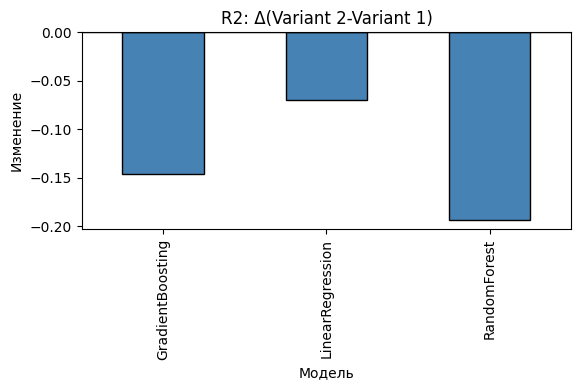

,ΔMAE (Variant 2-Variant 1),ΔMSE (Variant 2-Variant 1),ΔRMSE (Variant 2-Variant 1),ΔR2 (Variant 2-Variant 1),ΔSMAPE (Variant 2-Variant 1),Trend
Model,,,,,,
GradientBoosting,"1,001","31,505,090","1,360",-0,5,↓ ↓ ↓ ↓ ↓
LinearRegression,391,"15,028,426",560,-0,2,↓ ↓ ↓ ↓ ↓
RandomForest,"1,734","41,772,938","2,302",-0,15,↓ ↓ ↓ ↓ ↓


In [ ]:
functions_car.compare_regression_metrics(results_new_filtered.sort_index(), results_new_del.sort_index())#Результаты ухудшились

In [ ]:
#Подбор гиперпараметров
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

models = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {
            'fit_intercept': [True, False]
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(random_state=SEED),
        'params': {
            'n_estimators': [100, 200, 500],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5, 10]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=SEED),
        'params': {
            'n_estimators': [100, 200, 500],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7]
        }
    }
}


In [ ]:
best_models = {}

for name, config in models.items():
    print(f"=== {name} ===")
    gs = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        scoring='neg_mean_absolute_error',
        cv=5,
        n_jobs=-1, 
        verbose=2
    )
    gs.fit(X_train_preprocessed_filtered, y_train_filtered)
    
    print("Best params:", gs.best_params_)
    print("Best MAE:", -gs.best_score_)
    
    best_models[name] = gs.best_estimator_

In [70]:

# RandomForest с лог-таргетом
rf = RandomForestRegressor(random_state=SEED)
rf_log = TransformedTargetRegressor(
    regressor=rf,
    func=np.log1p,
    inverse_func=np.expm1
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", rf_log)
])

param_grid = {
    "model__regressor__n_estimators": [100, 200, 500],
    "model__regressor__max_depth": [None,10, 20, 30],
    "model__regressor__min_samples_split": [2, 5, 10]
}

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1,
    verbose=2
)


gs.fit(X_train_filtered, y_train_filtered)


print("Best params:", gs.best_params_)
print("Best MAE:", -gs.best_score_)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best params: {'model__regressor__max_depth': None, 'model__regressor__min_samples_split': 2, 'model__regressor__n_estimators': 500}
Best MAE: 4252.547477802128


In [ ]:
#Best params: {'model__regressor__max_depth': None, 'model__regressor__min_samples_split': 2, 'model__regressor__n_estimators': 500}
#Best MAE: 4252.547477802128